In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from collections import defaultdict

In [3]:
stats_df = pd.read_csv('./dsl_statistics.csv', index_col='Index')
manual_df = pd.read_csv('./manual_dsl_statistics.csv')

stats_df = stats_df.merge(manual_df, on='game_name')

In [6]:
stats_df.loc[stats_df.terminal_exists.isna(), 'terminal_exists'] = False

room = np.zeros((len(stats_df),), dtype=np.int)
room[['medium' in d for d in stats_df.domain_name]] = 1
room[['many' in d for d in stats_df.domain_name]] = 2

room_name = ['Few'] * len(stats_df)
stats_df = stats_df.assign(room=room, room_name=room_name)

stats_df.loc[['medium' in d for d in stats_df.domain_name], 'room_name'] = 'Medium'
stats_df.loc[['many' in d for d in stats_df.domain_name], 'room_name'] = 'Many'


In [8]:
DIFFICULTIES = ('Very Easy', 'Easy', 'Medium', 'Hard', 'Very Hard')
ROOM_NAMES = ('Few', 'Medium', 'Many')

In [7]:
stats_df.head()

,game_name,domain_name,length_of_then,num_preferences,setup_objects_quantified,preference_objects_quantified,terminal_exists,object_types_quantified,is_throwing,is_construction,difficulty,first_time_points,room,room_name
0,few-objects-2,few-objects-room-v1,3.0,2,2.0,2.5,False,"{'hexagonal_bin': 3, 'chair': 2, 'dodgeball': 2}",1,0,2,10.0,0,Few
1,few-objects-3,few-objects-room-v1,NaN,2,1.0,1.5,False,"{'desktop': 1, 'laptop': 1, 'cube_block': 3}",0,1,5,1.0,0,Few
2,few-objects-4,few-objects-room-v1,3.0,1,2.0,3.0,True,"{'wall': 2, 'hexagonal_bin': 2, 'dodgeball': 1}",1,0,2,14.0,0,Few
3,few-objects-5,few-objects-room-v1,3.0,2,4.0,2.5,True,"{'curved_wooden_ramp': 2, 'hexagonal_bin': 2, ...",1,0,4,3.0,0,Few
4,few-objects-7,few-objects-room-v1,3.0,1,2.0,3.0,False,"{'curved_wooden_ramp': 2, 'hexagonal_bin': 2, ...",1,0,1,5.0,0,Few


# Readme:
* `game_name`: room-\[row number in my spreadsheet\].
* `domain_name`: the room identifier as it's iun the games (domain is a PDDL thing)
* `length_of_then`: average length of all `then` clauses in this game.
* `num_preferences`: how many preferences I used to represent the game.
* `setup/preference_objects_quantified`: average number of objects quantified over in quantifiers (`exists`/`forall`) in the game representation, split by which section of the game it's in.
* `terminal_exists`: whether the game uses a `terminal` clause.
* `object_types_quantified`: how many times each object type was quantified in each game, combined between the setup and preferences. 
* `is_throwing/construction`: a manual labeling I provided by reviewing the game. Most games are either, some are both, some are neither. I decided that construction games are only those involving construction in the actual gameplay ("build a tower to max height"), and not those where there's some element of construction in the setup ("stack blocks and then throw a ball to knock them over"). We could discuss/change this classification.
* `difficuly/first_time_points`: data we collected from the participants about their games. The `DIFFICULTIES` variables above decodes, but 1 is "very easy", 5 is "very hard", and the rest follow.
* `room/room_name`: simplifications of the room designation from the game/domain names to ease working with the data.

## Participant rating vs. ther difficulty listed

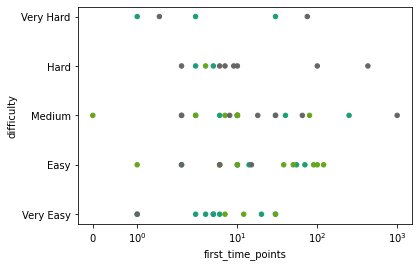

In [9]:
ax = stats_df.plot(x='first_time_points', y='difficulty', kind='scatter', c='room', colormap='Dark2', colorbar=False, logx='sym', yticks=np.arange(1, 6))
ax.set_yticklabels(DIFFICULTIES)
plt.show()

## Number of preferences histogram by room type

<AxesSubplot:title={'center':'Number of Preferences'}, ylabel='Frequency'>

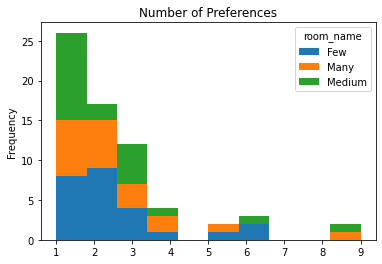

In [10]:
stats_df.pivot(columns='room_name').num_preferences.plot(kind='hist', stacked=True, title='Number of Preferences')

## Average number of objects quantified in the setup/preferences

Text(0, 0.5, 'Count')

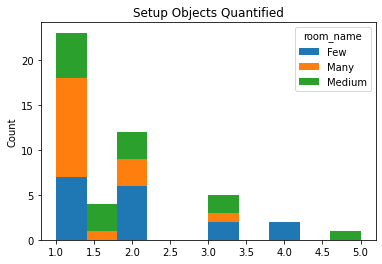

In [11]:
ax = stats_df.pivot(columns='room_name').setup_objects_quantified.plot(kind='hist', stacked=True, title='Setup Objects Quantified')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

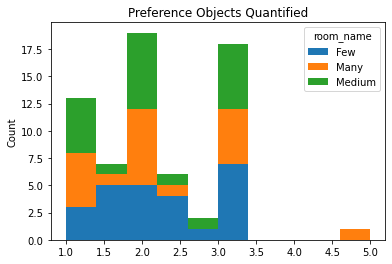

In [12]:
ax = stats_df.pivot(columns='room_name').preference_objects_quantified.plot(kind='hist', stacked=True, title='Preference Objects Quantified')
ax.set_ylabel('Count')

## Average length of 'then' clauses

Text(0, 0.5, 'Count')

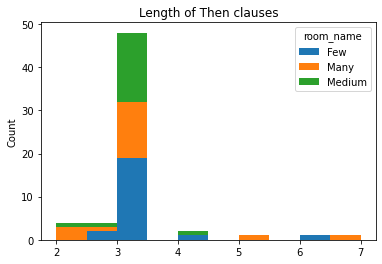

In [13]:
ax = stats_df.pivot(columns='room_name').length_of_then.plot(kind='hist', stacked=True, title='Length of Then clauses')
ax.set_ylabel('Count')

## Comment on the above
The above three plots are all currently all averaged within each game -- so I provide one number for each game that's the average length of its `then` clauses, or or the average number of objects quantified in each preference in that game. 

Would it be more interesting if I provided and plotted each individual preference? 

## Parsing the types/counts of objects quantified

In [20]:
results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))

for i, (object_types, room_name) in stats_df.loc[:, ('object_types_quantified', 'room_name')].iterrows():
    object_types = json.loads(object_types.replace("'", '"'))
    for obj_type, count in object_types.items():
        results[obj_type][room_name]['games'] += 1
        results[obj_type][room_name]['references'] += count

result_rows = []
for obj_type, obj_results in results.items():
    for room_name, room_results in obj_results.items():
        result_rows.append((obj_type, room_name, room_results['games'], room_results['references']))

object_counts_df = pd.DataFrame.from_records(result_rows, 
    columns=('object_type', 'room_name', 'games', 'references'))
object_counts_df.head()
    

,object_type,room_name,games,references
0,hexagonal_bin,Few,10,21
1,hexagonal_bin,Medium,13,26
2,hexagonal_bin,Many,12,27
3,chair,Few,10,18
4,chair,Medium,2,6


# Readme
* `object_type`: the type of the object
* `room_name`: as above, the name of the room by the number of items
* `games`: how many games (for this room) refer to this object at least once, as part of quantifiers (`exists`/`forall`).
* `references`: how many total references appear to this object type in quantifiers in games of this type. 
* **Important**: I realize now that this undercounts -- since it only looks in references, and doesn't look in places where we directly refer to a non-quantified object (such as the desk or bed). I should think about how to fix that.

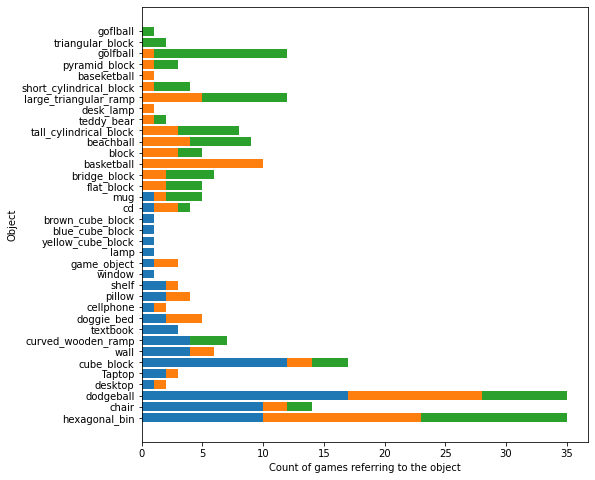

In [41]:
fig, ax = plt.subplots(figsize=(8, 8))

cumulative_start = defaultdict(lambda: 0)

for room_name in object_counts_df.room_name.unique():
    room_data = object_counts_df.loc[object_counts_df.room_name == room_name, ('object_type', 'games')]
    current_start = [cumulative_start[obj] for obj in room_data.object_type]
    ax.barh(room_data.object_type, room_data.games, left=current_start, label=room_name)

    for i, (obj, count) in room_data.iterrows():
        cumulative_start[obj] += count

ax.set_xlabel('Count of games referring to the object')
ax.set_ylabel('Object')
plt.show()

## Would the above be more interesting as...?**
* Fraction of the games that referred to the item?
    * ... from the games that could (that is, from the ones that had the type of object in the room)
* Counting the total quantifications, instead of only the number of games that refer to a particular type?
    * Graph with the total quantifications below:
* Makes some sort of aggregation? Balls, blocks, etc.?
* Separated between setup and preferences?
* **Important**: I realize now that this undercounts -- since it only looks in references, and doesn't look in places where we directly refer to a non-quantified object (such as the desk or bed). I should think about how to fix that.


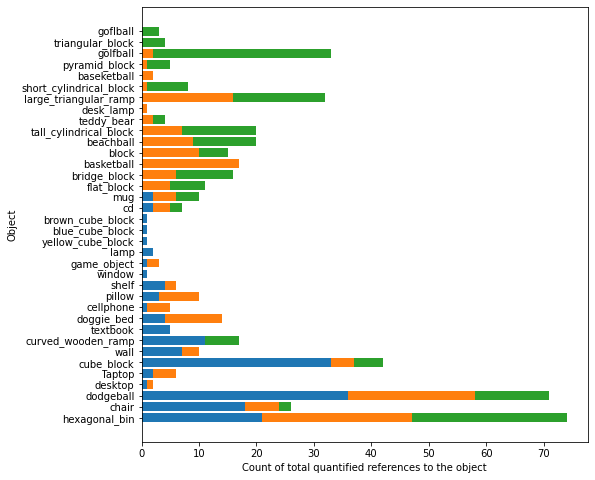

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))

cumulative_start = defaultdict(lambda: 0)

for room_name in object_counts_df.room_name.unique():
    room_data = object_counts_df.loc[object_counts_df.room_name == room_name, ('object_type', 'references')]
    current_start = [cumulative_start[obj] for obj in room_data.object_type]
    ax.barh(room_data.object_type, room_data.references, left=current_start, label=room_name)

    for i, (obj, count) in room_data.iterrows():
        cumulative_start[obj] += count

ax.set_xlabel('Count of total quantified references to the object')
ax.set_ylabel('Object')
plt.show()